# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Requirement already up-to-date: pillow in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (7.2.0)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Extracting Annotations from XML Format

In [3]:
xml_dir = 'data/annotations/xmls/'
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == 'xml']
xml_files[0]

'data/annotations/xmls/havanese_175.xml'

In [4]:
classes = ['cat', 'dog']
categories = [
    {
        'class_id': 0,
        'name': 'cat'
    },
    {
        'class_id': 1,
        'name': 'dog'
    }
]

In [5]:
def extract_annotation(xml_file_path):
    
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}
    
    annotation['file'] = root.find('filename').text
    annotation['categories'] = categories
    
    size = root.find('size')
    
    annotation['image_size'] = [{
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }]
    
    annotation['annotations'] = []
    
    for item in root.iter('object'):
        class_id = classes.index(item.find('name').text)
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in item.findall('bndbox'):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
        
            if all([xmin, ymin, xmax, ymax]) is not None:
                 annotation['annotations'].append({
                     'class_id': class_id,
                     'left': xmin,
                     'top': ymin,
                     'width': xmax - xmin,
                     'height': ymax - ymin
                 })
    return annotation

In [6]:
extract_annotation(xml_files[0])

{'file': 'havanese_175.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 429, 'height': 500, 'depth': 3}],
 'annotations': [{'class_id': 1,
   'left': 10,
   'top': 12,
   'width': 383,
   'height': 305}]}

# Visualize Data

In [7]:
def plot_example(plt, annot, image_file_path, rows, cols, index):
    img = Image.open(image_file_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 20)
    
    for a in annot['annotations']:
        box = [
            int(a['left']), int(a['top']),
            int(a['left']) + int(a['width']),
            int(a['top']) + int(a['height'])
        ]
        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(a['class_id'])], font=font)
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return plt

def show_random_annotations(plt):
    plt.figure(figsize=(16, 16))
    for i in range(0, 9):
        index = random.randint(0, len(xml_files) - 1)
        
        annot = extract_annotation(xml_files[index])
        image_file_path = os.path.join('data/images/', annot['file'])

        plt = plot_example(plt, annot, image_file_path, 3, 3, i)
    plt.show()

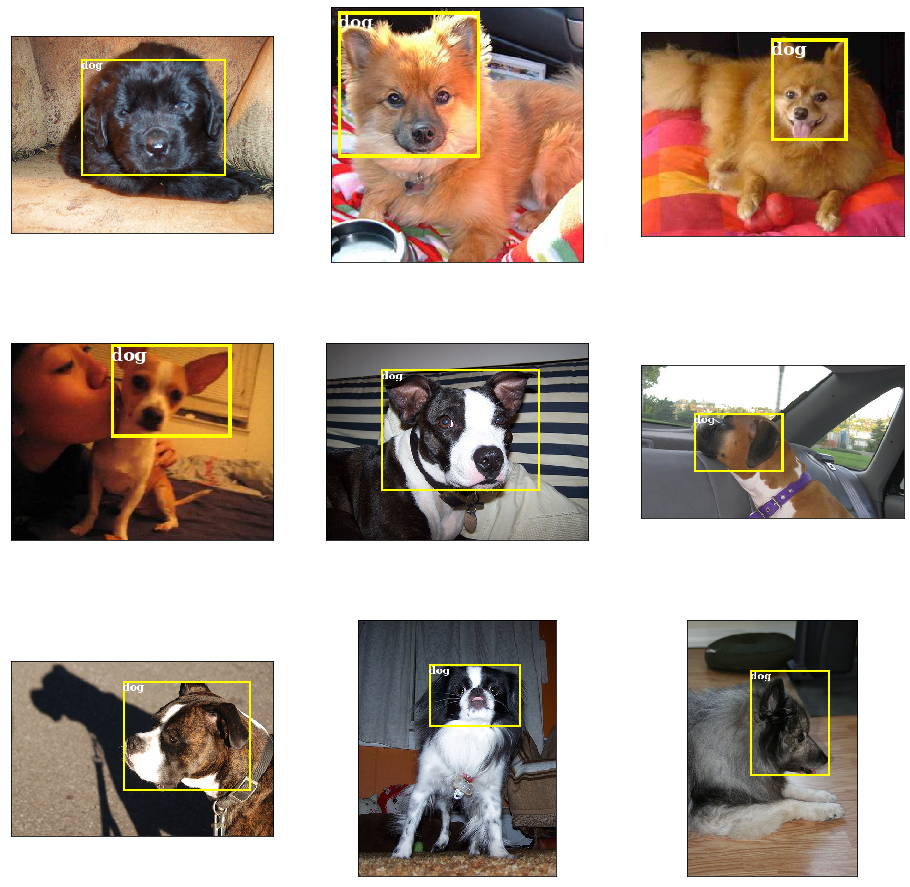

In [8]:
show_random_annotations(plt)

# SageMaker Setup

In [9]:
# set s3 bucket
role = sagemaker.get_execution_role()
bucket_name = 'yuan9606' 


training_image = get_image_uri(boto3.Session().region_name, 'object-detection', repo_version='latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


In [10]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [11]:
print('Total examples:', len(xml_files))

Total examples: 3686


In [12]:
for xml_file in tqdm(xml_files):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'  # 75% for training, 25% for val
    annot = extract_annotation(xml_file)
    image_file_path = os.path.join('data/images/', annot['file'])
    image_target_path = os.path.join(target_set, annot['file'])
    shutil.copy(image_file_path, image_target_path)
    json_file_path = os.path.join(target_set + '_annotation', annot['file'][:-3] + 'json')
    with open(json_file_path, 'w') as f:
        json.dump(annot, f)

100%|██████████| 3686/3686 [00:01<00:00, 2231.07it/s]


In [13]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [14]:
print(len(train_annots), len(train_images))

2772 2772


In [15]:
for image in train_images:     # check img and its annot both exists (for each)
    key = image.split('.')[0]
    json_file = key + '.json'
    if json_file not in train_annots:
        print('Not found', json_file)

# Uploading Data to S3

In [16]:
sess = sagemaker.Session()
print('Uploading data .. ')

# X_train 
s3_train_path = sess.upload_data(path = 'train', bucket = bucket_name, key_prefix = 'train')
print('Training images updoaded')
# X_val
s3_validation_path = sess.upload_data(path='validation', bucket = bucket_name, key_prefix = 'validation')
print('Validation images updoaded')
# y_train
s3_train_annotation = sess.upload_data(path = 'train_annotation', bucket = bucket_name, key_prefix = 'train_annotation')
print('Training annotations updoaded')
# y_val
s3_validation_annotation = sess.upload_data(path='validation_annotation', bucket = bucket_name, key_prefix = 'validation_annotation')
print('Validation annotations updoaded')


Uploading data .. 
Training images updoaded
Validation images updoaded
Training annotations updoaded
Validation annotations updoaded


In [17]:
s3_train_annotation

's3://yuan9606/train_annotation'

# SageMaker Estimator

In [61]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_type = 'ml.m4.xlarge',  # no suitable instance satisfied in this starter account
    train_instance_count = 1,
    train_volume_size = 100,
    train_max_run = 30000,
    input_mode = 'File',
    output_path = 's3://yuan9606/output',
    sagemaker_session = sess
)



# In Starter Accounts only following instance types are allowed:
# ml.t2.medium
# ml.t2.large
# ml.t3.medium
# ml.t3.large
# ml.g4dn.xlarge (only in classrooms)
# ml.c5.large (*Not supported in all Starter Accounts or
# Classrooms)
# ml.m5.large (*Not supported in all Starter Accounts or
# Classrooms)



# Member must satisfy enum value set:
#     [ml.p2.xlarge, ml.m5.4xlarge, ml.m4.16xlarge, ml.c5n.xlarge,
#      ml.p3.16xlarge, ml.m5.large, ml.p2.16xlarge, ml.c4.2xlarge, 
#      ml.c5.2xlarge, ml.c4.4xlarge, ml.c5.4xlarge, ml.c5n.18xlarge,
#      ml.g4dn.xlarge, ml.g4dn.12xlarge, ml.c4.8xlarge, ml.g4dn.2xlarge,
#      ml.c5.9xlarge, ml.g4dn.4xlarge, ml.c5.xlarge, ml.g4dn.16xlarge,
#      ml.c4.xlarge, ml.g4dn.8xlarge, ml.c5n.2xlarge, ml.c5n.4xlarge,
#      ml.c5.18xlarge, ml.p3dn.24xlarge, ml.p3.2xlarge, ml.m5.xlarge,
#      ml.m4.10xlarge, ml.c5n.9xlarge, ml.m5.12xlarge, ml.m4.xlarge, 
#      ml.m5.24xlarge, ml.m4.2xlarge, ml.p2.8xlarge, ml.m5.2xlarge, ml.p3.8xlarge, ml.m4.4xlarge]

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

In [62]:
model.set_hyperparameters(
    base_network = 'resnet-50',
    num_classes = 2,
    use_pretrained_model = 1,
    mini_batch_size = 16,
    epoches = 15,
    learning_rate = 0.001,
    optimizer = 'sgd',
    lr_scheduler_step = '10',
    lr_scheduler_factor = 0.1,
    momentum = 0.9,
    weight_decay = 0.0005,
    overlap_threshold = 0.5,
    nms_threshold = 0.45,
    image_shape = 512,
    num_training_samples = len(train_annots)
)

# Data Channels

In [63]:
from sagemaker.session import s3_input

train_data = sagemaker.session.s3_input(s3_train_path,
                                        distribution = 'FullyReplicated',
                                        content_type = 'application/x-image', 
                                        s3_data_type = 'S3Prefix')
 
validation_data = sagemaker.session.s3_input(s3_validation_path,
                                             distribution = 'FullyReplicated',
                                             content_type = 'application/x-image', 
                                             s3_data_type = 'S3Prefix')

train_annotation_data = sagemaker.session.s3_input(s3_train_annotation,
                                                   distribution = 'FullyReplicated',
                                                   content_type = 'application/x-image', 
                                                   s3_data_type = 'S3Prefix')

validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation,
                                                        distribution = 'FullyReplicated',
                                                        content_type = 'application/x-image', 
                                                        s3_data_type = 'S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [64]:
data_channels = {
    'train': train_data,
    'validation' : validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation' : validation_annotation_data,
}

In [65]:
data_channels

{'train': <sagemaker.inputs.s3_input at 0x7f119949eac8>,
 'validation': <sagemaker.inputs.s3_input at 0x7f11995b9dd8>,
 'train_annotation': <sagemaker.inputs.s3_input at 0x7f11995b9e48>,
 'validation_annotation': <sagemaker.inputs.s3_input at 0x7f11995b9908>}

# Model Training

In [66]:
model.fit(inputs = data_channels, logs = True)

ClientError: An error occurred (ValidationException) when calling the CreateTrainingJob operation: 1 validation error detected: Value 'ml.c5.large' at 'resourceConfig.instanceType' failed to satisfy constraint: Member must satisfy enum value set: [ml.p2.xlarge, ml.m5.4xlarge, ml.m4.16xlarge, ml.c5n.xlarge, ml.p3.16xlarge, ml.m5.large, ml.p2.16xlarge, ml.c4.2xlarge, ml.c5.2xlarge, ml.c4.4xlarge, ml.c5.4xlarge, ml.c5n.18xlarge, ml.g4dn.xlarge, ml.g4dn.12xlarge, ml.c4.8xlarge, ml.g4dn.2xlarge, ml.c5.9xlarge, ml.g4dn.4xlarge, ml.c5.xlarge, ml.g4dn.16xlarge, ml.c4.xlarge, ml.g4dn.8xlarge, ml.c5n.2xlarge, ml.c5n.4xlarge, ml.c5.18xlarge, ml.p3dn.24xlarge, ml.p3.2xlarge, ml.m5.xlarge, ml.m4.10xlarge, ml.c5n.9xlarge, ml.m5.12xlarge, ml.m4.xlarge, ml.m5.24xlarge, ml.m4.2xlarge, ml.p2.8xlarge, ml.m5.2xlarge, ml.p3.8xlarge, ml.m4.4xlarge]

# Deploy Model

In [ ]:
deploy_model = model.deploy(initial_instance_count=1, instance_type = 'ml.m4.xlarge')
print('\nmodel deployed!')

# Predictions

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [ ]:
deployed_model.content_type = 'image/jpeg'

In [ ]:
index = 0

image_path = os.path.join(image_dir, images[index])
#image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read()) # format for inference

results = deployed_model.predict(b)
results = json.loads(results)

#print(results)

preds = results['prediction']

In [ ]:
preds[0]  # class, confidence, x, y, w, h

In [ ]:
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 30)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = pred
    
    if score > 0.7:
        box = [w*xmin, h*ymin, w*xmax, h*ymax]

        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(class_id)], font=font, fill='#000000')
    else:
        break

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [67]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

NameError: name 'deployed_model' is not defined